# Modeling- Ensemble Of Brackets

- Robert Shaw
- CS109a Project: Data Driven March Madness

In this file, we test code that allows us to predict 10 different brackets that are much different from one another. This strategy allows us to succeed in the ESPN bracket challenge, in which the maximum score across 10 possible brackets is most important. As such, we want to include a lot of diversity in our 10 brackets.

In [35]:
import march_madness_classes as mmc
import march_madness_games as mmg
import march_madness_models as mmm
import march_madness_train_and_tune as mmtt

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression as LogReg

In [2]:
# read in the dataset
seeds = pd.read_csv("datasets/kaggle_data/TourneySeeds.csv")
slots = pd.read_csv("datasets/kaggle_data/TourneySlots.csv")
games = pd.read_csv("datasets/kaggle_data/TourneyCompactResults.csv")

seeds_arr = mmg.filter_into_seasons(seeds)
slots_arr = mmg.filter_into_seasons(slots)
games_arr = mmg.filter_into_seasons(games)

In [3]:
# extract predictors
markov_data = pd.read_csv("datasets/our_data/stationary", index_col=0)
rpi = pd.read_csv("datasets/our_data/rpi", index_col=0)
bad_losses = pd.read_csv("datasets/our_data/bad_losses", index_col=0)

In [4]:
# get data into correct format
predictor_names = ["min_index_id", "max_index_id", "markov", "rpi", "bad_losses"]
predictor_dfs = [markov_data, rpi, bad_losses]                                        

#### Train Test Split - Windowing Approach 
- Each year's model is trained on the previous 3 years.

In [6]:
# trian test split

train_test_arr = []

window   = 3
min_year = 2000
max_year = 2014

year_range = range(min_year, max_year)

# generate our train test split for each year
for year in year_range:
    # do the split for the current year
    train_test_tuple = mmtt.train_test_split(window, 
                                             year, 
                                             seeds_arr, 
                                             slots_arr, 
                                             games_arr, 
                                             predictor_names, 
                                             predictor_dfs)
    
    # add to our array
    train_test_arr.append(train_test_tuple)

#### Fit Head to Head Models
- See model selection for more information on how we created this head to head model.

In [7]:
# fit head to head models

# our cross validated value of c, from variable selection notebook
c = 1
variables = ["markov","rpi","bad_losses"] 

# models and scalers to be fit
models  = []
scalers = []

for year in year_range:
        # get train data
        train_x = train_test_arr[year - min_year][0][variables]
        train_y = train_test_arr[year - min_year][1].values[:, 0]

        # get cross validation set
        cross_x = train_test_arr[year - min_year][2][variables]
        cross_y = train_test_arr[year - min_year][3].values[:, 0]

        # scaling
        scaler = StandardScaler().fit(train_x)
        scaled_train_x = scaler.transform(train_x)
        scaled_cross_x = scaler.transform(cross_x)

        # init model
        model = LogReg(C=c)

        # fit model
        model.fit(scaled_train_x, train_y)
        
        # append to our lis of models
        models.append(model)
        scalers.append(scaler)

#### Run Baseline Tournament Models  - comparison
- Actual Results
- Low Seed Baseline
- Unbiased Single Model Baseline

In [8]:
# run tournaments

year = min_year
unbiased_tourneys   = []
top_seed_tourneys = []
actual_tourneys   = []

# analyze results for all simulations
i = 0
for year in year_range:
    # get data from our db
    seeds_year = seeds_arr[year-1985] 
    slots_year = slots_arr[year-1985] 
    games_year = games_arr[year-1985]
    
    # get actual models
    actual_model = mmm.ActualTournament(games_arr[year-1985])
    actual_tourneys.append(mmc.Tournament(seeds_year, slots_year, actual_model, include_scoring_dif=False))
    
    # get greedy models
    unbiased_model = mmm.ModelPredictor(models[i], scalers[i], predictor_dfs, year, seeds_year, simulation=False)
    unbiased_tourneys.append(mmc.Tournament(seeds_year, slots_year, unbiased_model, include_scoring_dif=False))
    
    # get top seed models
    top_seed_model = mmm.BasicPredictor()
    top_seed_tourneys.append(mmc.Tournament(seeds_year, slots_year, top_seed_model, include_scoring_dif=False))
    
    year = year + 1
    i = i + 1

#### Score Baseline Models - comparison
- Actual Results
- Low Seed Baseline
- Unbiased Single Model Baseline

In [11]:
# buffers
unbiased_scores = np.zeros(len(year_range))
top_seed_scores = np.zeros(len(year_range))

# analyze results 
year = min_year
i = 0
for i in range(len(year_range)):
    # get data from our db
    seeds_year = seeds_arr[year-1985] 
    slots_year = slots_arr[year-1985] 
    games_year = games_arr[year-1985]
    
    # get models
    actual_tourney = actual_tourneys[i]
    unbiased_tourney = unbiased_tourneys[i]
    top_seed_tourney = top_seed_tourneys[i]
    
    # score tournaments
    unbiased_scores[i], x = unbiased_tourney.score_tournament(actual_tourney, print_res=False)
    top_seed_scores[i], x = top_seed_tourney.score_tournament(actual_tourney, print_res=False)
    
    year = year + 1
    i = i + 1

In [12]:
print np.average(unbiased_scores)
print np.average(top_seed_scores)

940.714285714
855.714285714


#### Run Ensembles 
- Again, the ensemble of brackets is 10 brackets that a diverse from one another. The way that this works is we create 3 baseline models - unbiased, - early round upset bias, - late round upset bias (see Modeling- Optimizing For Tournament Structure.ipynb, for an explanation of this). We then have a cost function which biased the head to head predictions of the 7 derivative brackets, which change the threshold for prediction based on the similarity towards the other brackets. Through this hueristic method, we create 10 diverse brackets, which will give us a high "maximum score."

In [17]:
# buffers
ensembles = []

i = 0
for year in year_range:
    # get data from our db
    seeds_year = seeds_arr[year-1985] 
    slots_year = slots_arr[year-1985] 
    games_year = games_arr[year-1985]
    
    # setup ensembles
    ensembles.append(mmc.Ensemble(seeds_arr[year-1985], 
                                   slots_arr[year-1985], 
                                   models[i], 
                                   scalers[i],  
                                   predictor_dfs, 
                                   year))
    
    i = i + 1

#### Score Ensembles

In [95]:
# buffers
ensemble_scores = np.zeros(len(year_range))
ind_bracket_scores = np.zeros((len(year_range), 10))

ensemble_dif_matrix = np.zeros((len(year_range), 10, 10))
ensemble_avg_dif = np.zeros((len(year_range), 10))
ensemble_dif_top_seed = np.zeros((len(year_range), 10))

i = 0
for year in year_range:
    # get data from our db
    seeds_year = seeds_arr[year-1985] 
    slots_year = slots_arr[year-1985] 
    games_year = games_arr[year-1985]
    
    # setup ensembles
    ensemble_tournament = ensembles[i]
    
    # individual bracket scores
    ind_bracket_scores[i, :] = ensemble_tournament.score_tournament(actual_tourneys[i])
    # ensemble score
    ensemble_scores[i] = np.max(ind_bracket_scores[i, :])
    
    # difference between brackets
    ensemble_dif_matrix[i, :, :] = ensemble_tournament.compute_dif_matrix(actual_tourneys[i]) 
    ensemble_avg_dif[i, :] = ensemble_tournament.avg_game_dif()
    ensemble_dif_top_seed[i, :] =  ensemble_tournament.compute_dif_vect(actual_tourneys[i], top_seed_tourneys[i])
    
    i = i + 1

#### Analysis - Compare Scores of Ensemble to Unbiased Bracket

In [68]:
print ensemble_scores
print unbiased_scores

[  770.  1180.  1240.   740.  1020.  1460.   680.  1060.  1600.  1270.
   910.   530.  1530.  1120.]
[  690.  1150.   700.   720.   760.  1020.   620.   940.  1600.  1240.
   910.   450.  1250.  1120.]


In [69]:
dif_ensemble_unbiased = ensemble_scores - unbiased_scores

Avg Score Ensemble: 1079.28571429
Avg Score Unbiased: 940.714285714
Avg Score Baseline: 855.714285714


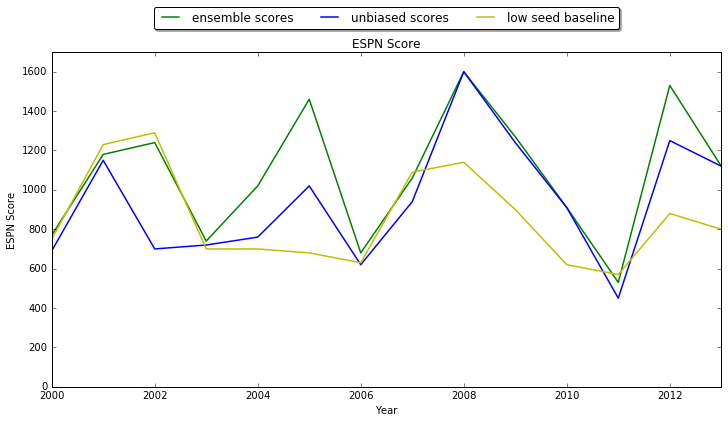

In [70]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.plot(year_range, ensemble_scores, color="g", label="ensemble scores", lw=1.5)
ax.plot(year_range, unbiased_scores, color="b", label="unbiased scores", lw=1.5)
ax.plot(year_range, top_seed_scores, color="y", label="low seed baseline", lw=1.5)
ax.set_xlabel("Year")
ax.set_ylabel("ESPN Score")
ax.set_title("ESPN Score")
ax.set_ylim([0, 1700])
ax.set_xlim([2000, 2013])
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

print "Avg Score Ensemble: {}".format(np.average(ensemble_scores))
print "Avg Score Unbiased: {}".format(np.average(unbiased_scores))
print "Avg Score Baseline: {}".format(np.average(top_seed_scores))

The ensemble beats the baseline and just using the unbiased model. Especially in 2002, 2005, and 2012. It shows that these diverse brackets are a good method for the ESPN Bracket Challenge, since all that matters is the best out of the 10 brackets.

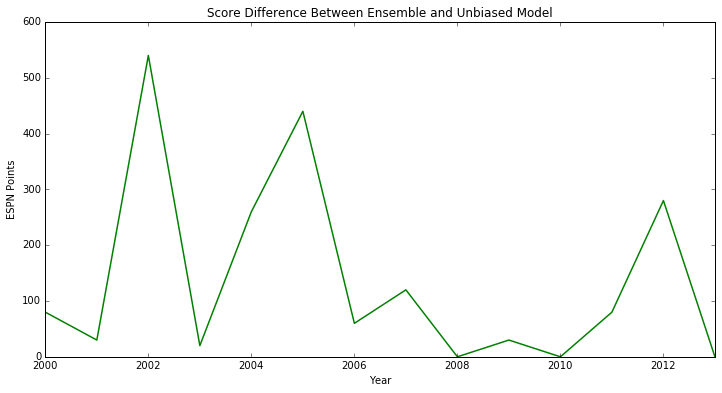

In [76]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.plot(year_range, dif_ensemble_unbiased, color="g", lw=1.5)
ax.set_xlabel("Year")
ax.set_ylabel("ESPN Points")
ax.set_title("Score Difference Between Ensemble and Unbiased Model")
ax.set_xlim([2000, 2013])
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

2002, 2005, and 2012 show the power of the ensemble.

#### Analysis - "Googliness" Of The Ensemble  
- Exploration of the intra-ensemble uniqueness. How much different was each bracket from all of the others.

In [111]:
legend_title = []
for i in range(10):
    legend_title.append("Bracket {}".format(i))

Avg N Games Dif Intra-Ensemble : 10.8841269841


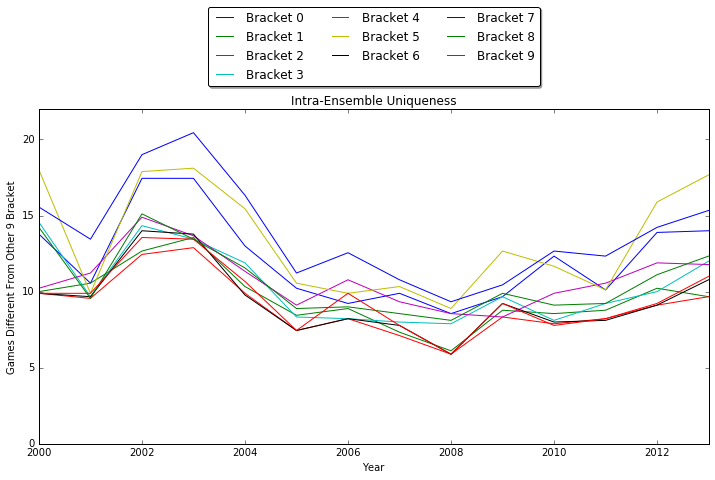

In [120]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

lines = ax.plot(year_range, ensemble_avg_dif)
for i in range(len(lines)):
    lines[i].label = legend_title[i]
ax.set_xlim([2000, 2013])
ax.set_ylim([0,22])
ax.set_xlabel("Year")
ax.set_ylabel("Games Different From Other 9 Bracket")
ax.set_title("Intra-Ensemble Uniqueness")
ax.legend(iter(lines), legend_title, loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

print "Avg N Games Dif Intra-Ensemble : {}".format(np.average(ensemble_avg_dif))

Each bracket is about 10 games different from all of the other brackets on average. We could also tune the bias to induce higher differences between brackets.

Avg N Games Dif From Top Seed : 14.2642857143


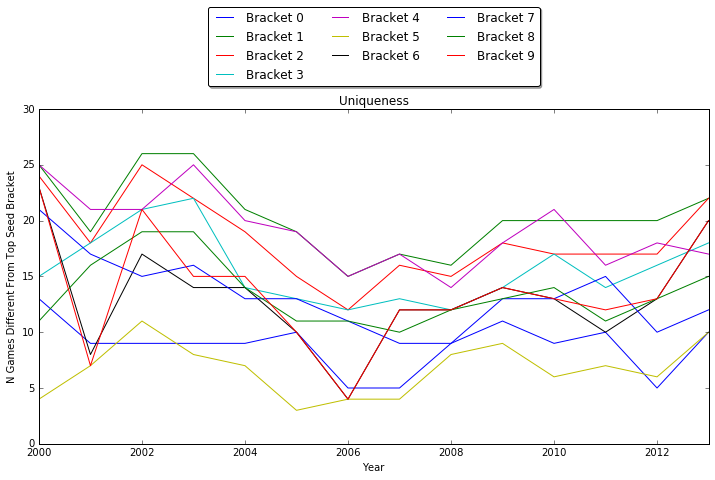

In [127]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

lines = ax.plot(year_range, ensemble_dif_top_seed)
ax.set_xlim([2000, 2013])
ax.set_ylim([0,30])
ax.set_xlabel("Year")
ax.set_ylabel("N Games Different From Top Seed Bracket")
ax.set_title("Uniqueness")
for i in range(len(lines)):
    lines[i].label = legend_title[i]
ax.legend(iter(lines), legend_title, loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

print "Avg N Games Dif From Top Seed : {}".format(np.average(ensemble_dif_top_seed))

Each bracket in the ensemble itself is also quite unique, getting on average about 14 games different from the low seed baseline. Obviously, some are more extreme than others, which is good, since it allows us to get a high score in years with many upsets and with few upsets.